# 🏡 **Bengaluru House Price Prediction**

In [73]:
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
import sklearn
import xgboost



# 📜 Problem Statement

### By analyzing these Bengaluru house data, we will determine the approximate price for the houses.

# 📊 Dataset Overview

---

<div style="color: white; display: fill; border-radius: 5px; background-color: #D3D3D3; font-size: 100%; font-family: Verdana; padding: 7px;">
    <h2>Data Description</h2>
    <ul style="padding-left: 20px; color: black;">
        <li>📌 <b>Area_type</b> - Description of the area</li>
        <li>📌 <b>Availability</b> - When it can be possessed or when it is ready</li>
        <li>📌 <b>Location</b> - Where it is located in Bengaluru</li>
        <li>📌 <b>Size</b> - BHK or Bedrooms</li>
        <li>📌 <b>Society</b> - To which society it belongs</li>
        <li>📌 <b>Total_sqft</b> - Size of the property in sq.ft</li>
        <li>📌 <b>Bath</b> - No. of Bathrooms</li>
        <li>📌 <b>Balcony</b> - No. of the Balcony</li>
        <li>📌 <b>Price</b> - Value of the property in lakhs (Indian Rupee - <b>₹</b>)</li>
    </ul>
</div>

---

In [74]:
home = pd.read_csv("data/Bengaluru_House_Data.csv")
home.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


<h3 style="background-color: #e9ecef; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #495057; 
           border: 2px solid #adb5bd; 
           border-radius: 8px">
<br> <small style="color: #6c757d;">Exploratory Data Analysis (EDA)</small>
</h3>

In [75]:
home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


## Data Preprocessing!

In [76]:


round(100*(home.isnull().sum()/len(home.index)),2)

area_type        0.00
availability     0.00
location         0.01
size             0.12
society         41.31
total_sqft       0.00
bath             0.55
balcony          4.57
price            0.00
dtype: float64

<h3 style="background-color: #f8f9fa; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #343a40; 
           border: 2px solid #6c757d; 
           border-radius: 8px">
Removing NaN Values and Unnecessary Columns
</h3>

In [77]:
home.dropna(inplace =True)

In [78]:
home = home.drop(columns='society')

In [79]:
home.reset_index(drop= True, inplace =True)

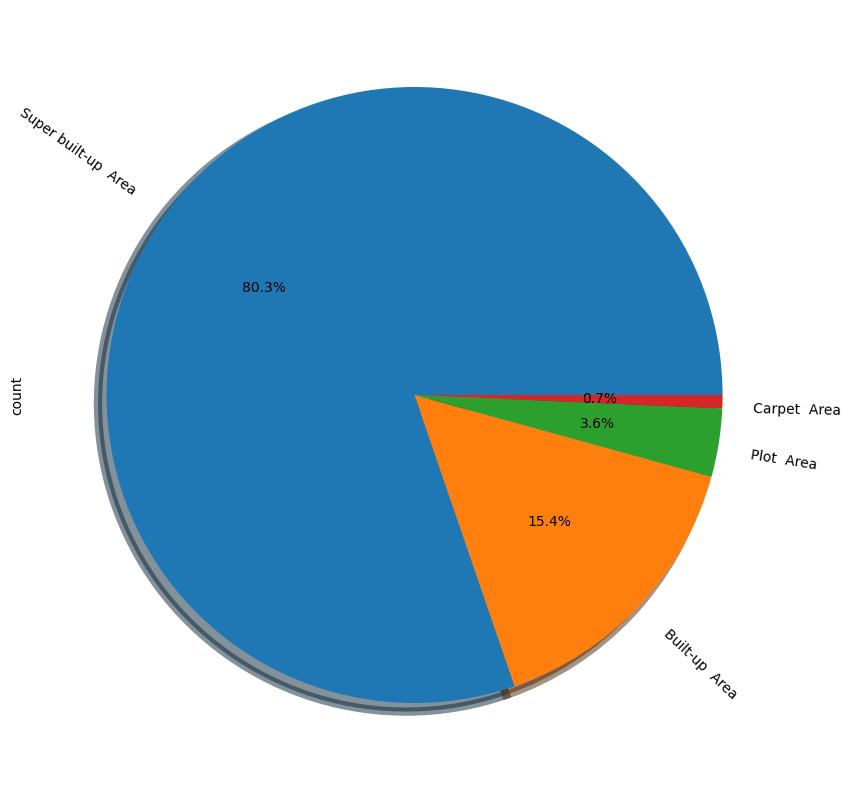

In [35]:
(home["area_type"].value_counts()).plot.pie(autopct="%.1f%%", shadow=True,rotatelabels=True, wedgeprops={'linewidth': 6}, radius=1)
plt.show()

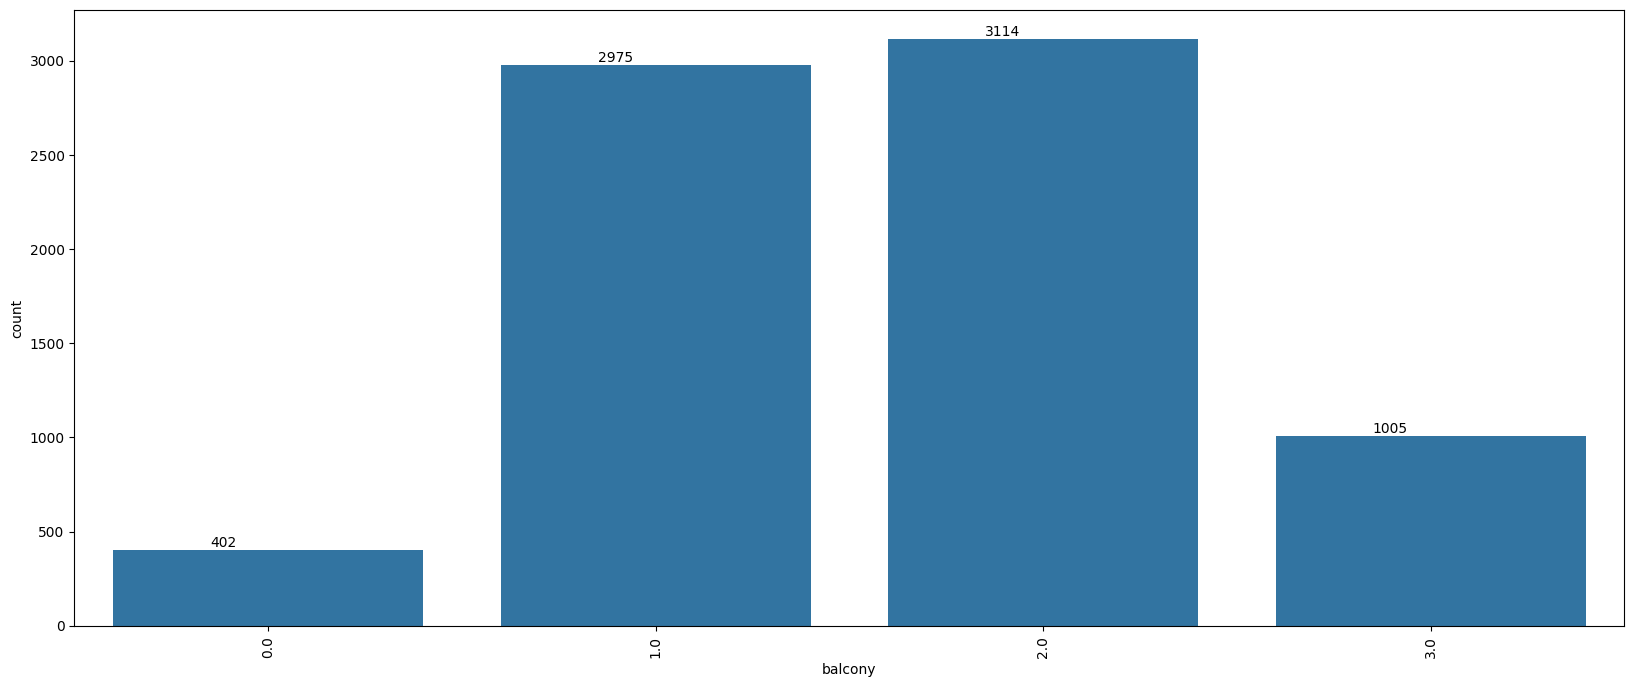

In [36]:
plt.figure(figsize = (20,8))
ax=sns.countplot(x = 'balcony', data = home)
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va = 'bottom', color = 'black')

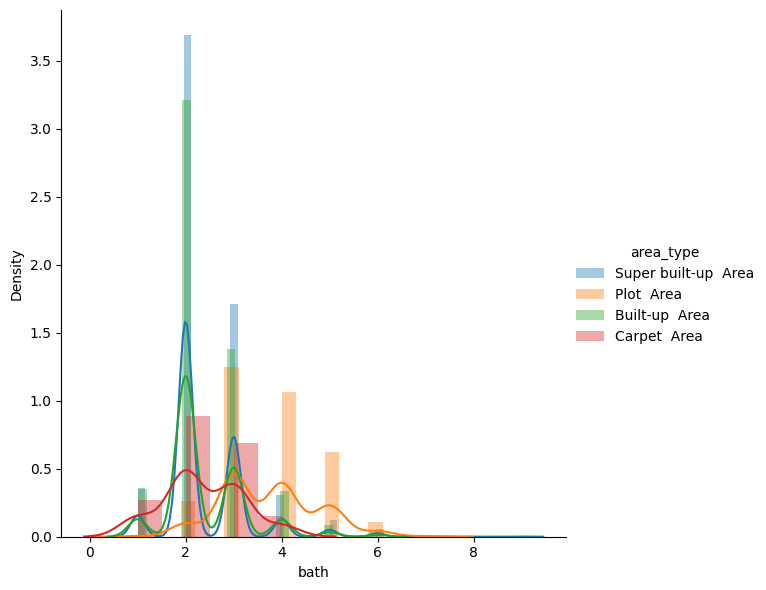

In [37]:
import warnings
warnings.filterwarnings('ignore')

sns.FacetGrid(home, hue='area_type', height=6).map(sns.distplot, 'bath').add_legend()
plt.show()

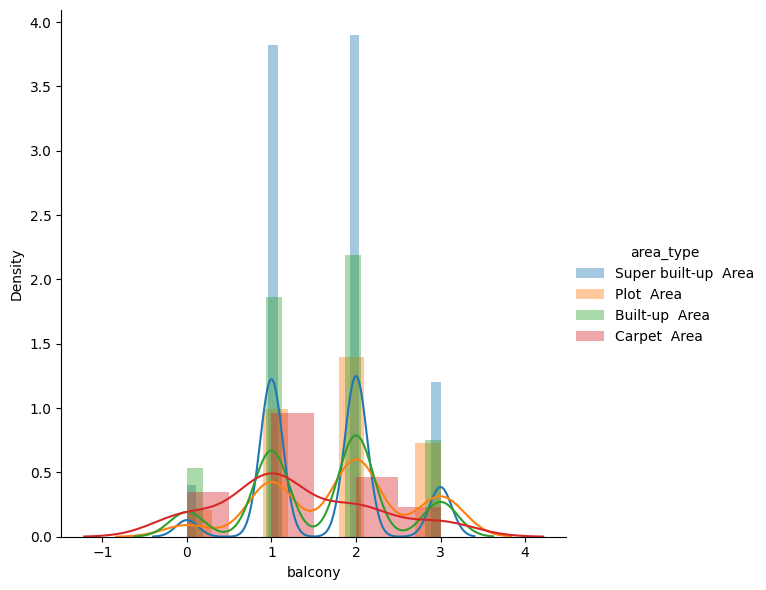

In [38]:
sns.FacetGrid(home, hue='area_type', height=6).map(sns.distplot, 'balcony').add_legend()
plt.show()

<h3 style="background-color: #f1f3f5; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #212529; 
           border: 2px solid #ced4da; 
           border-radius: 8px">
Extracting BHK from Size Column
</h3>

In [80]:
home['bhk'] = home['size'].str.split().str[0]
home['bhk'].dropna(inplace = True)
home['bhk'] = home['bhk'].astype('int')

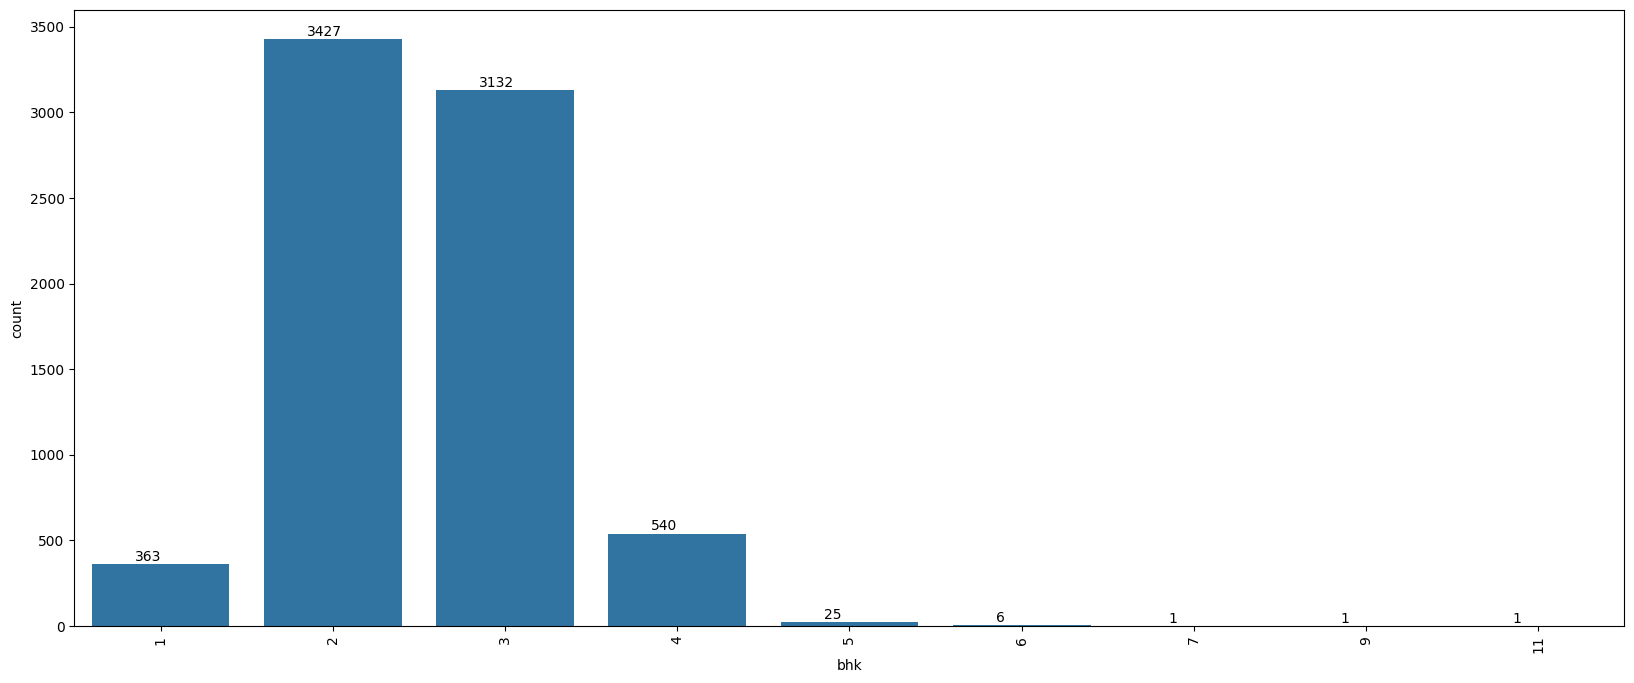

In [40]:
plt.figure(figsize = (20,8))
ax=sns.countplot(x = 'bhk', data = home)
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va = 'bottom', color = 'black')

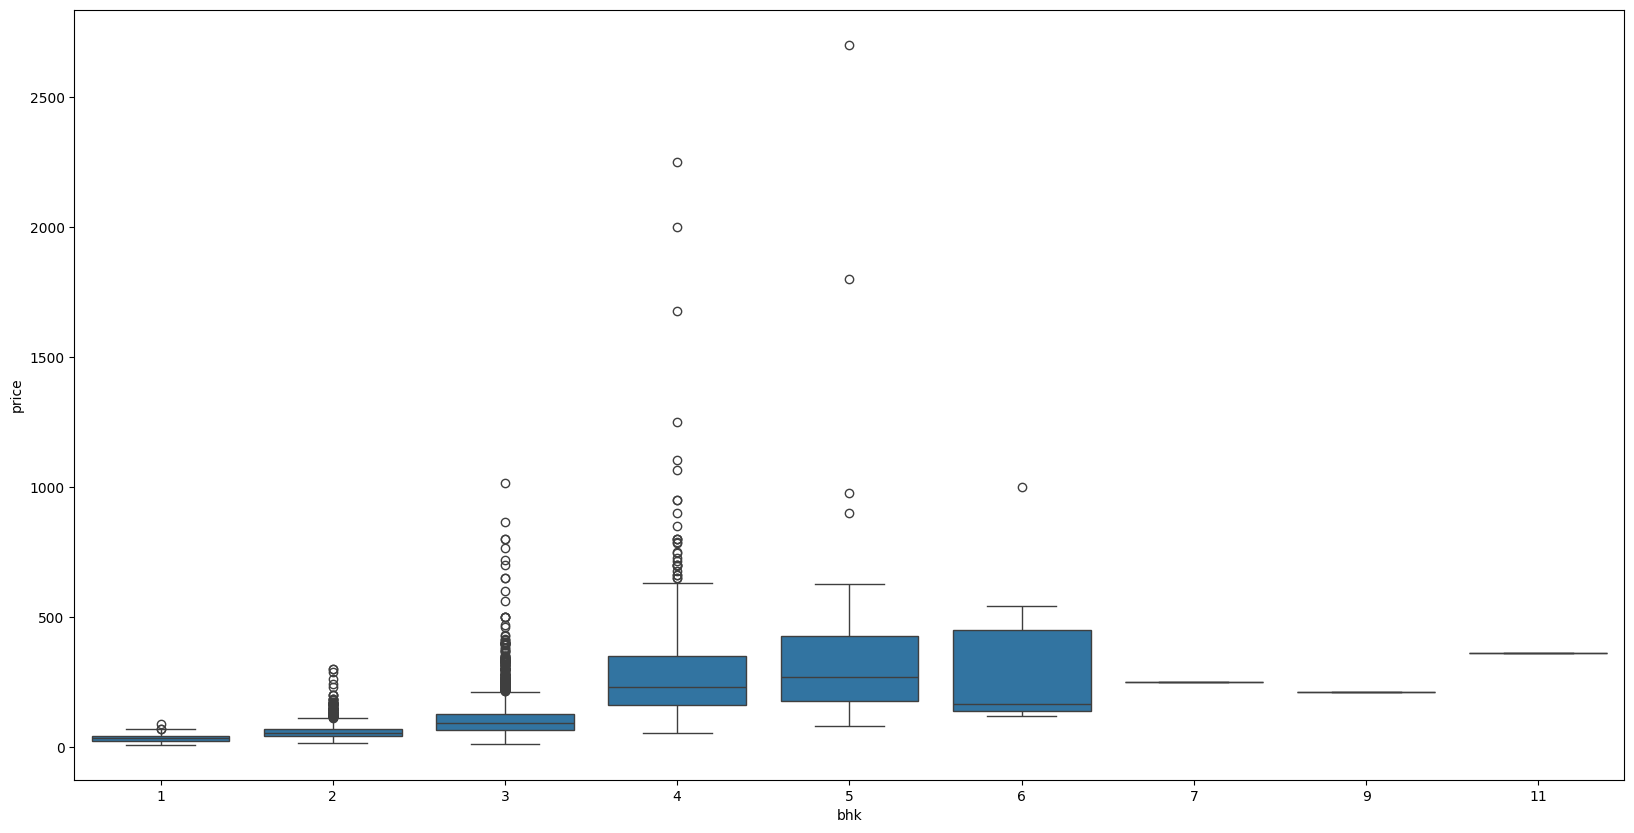

In [41]:
sns.boxplot(x = 'bhk', y = 'price', data = home)
plt.show()

In [81]:
print(home['total_sqft'].iloc[[17]])

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

17    2100 - 2850
Name: total_sqft, dtype: object


In [82]:
home.total_sqft = home.total_sqft.apply(convert_sqft_to_num)
home = home[home.total_sqft.notnull()]
home.head(2)

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4


<h3 style="background-color: #e9ecef; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #495057; 
           border: 2px solid #adb5bd; 
           border-radius: 8px">
Removing Invalid Data Entries <br> <small style="color: #6c757d;">Example: The total sqft divided by the number of BHK should always be more than 300</small>
</h3>

In [83]:
home = home[~(home.total_sqft/home.bhk<200)]
home.shape

(7478, 9)

<h3 style="background-color: #f8f9fa; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #343a40; 
           border: 2px solid #6c757d; 
           border-radius: 8px">
Dividing the Dataset into Continuous and Categorical Variables
</h3>

In [84]:
cont_ = home.select_dtypes(exclude = 'object')
cat_ = home.select_dtypes(include  = 'object')

<h3 style="background-color: #f1f3f5; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #212529; 
           border: 2px solid #ced4da; 
           border-radius: 8px">
Displaying Continuous Variables <br> <small style="color: #6c757d;">To determine which variables have outliers and which need to be removed</small>
</h3>

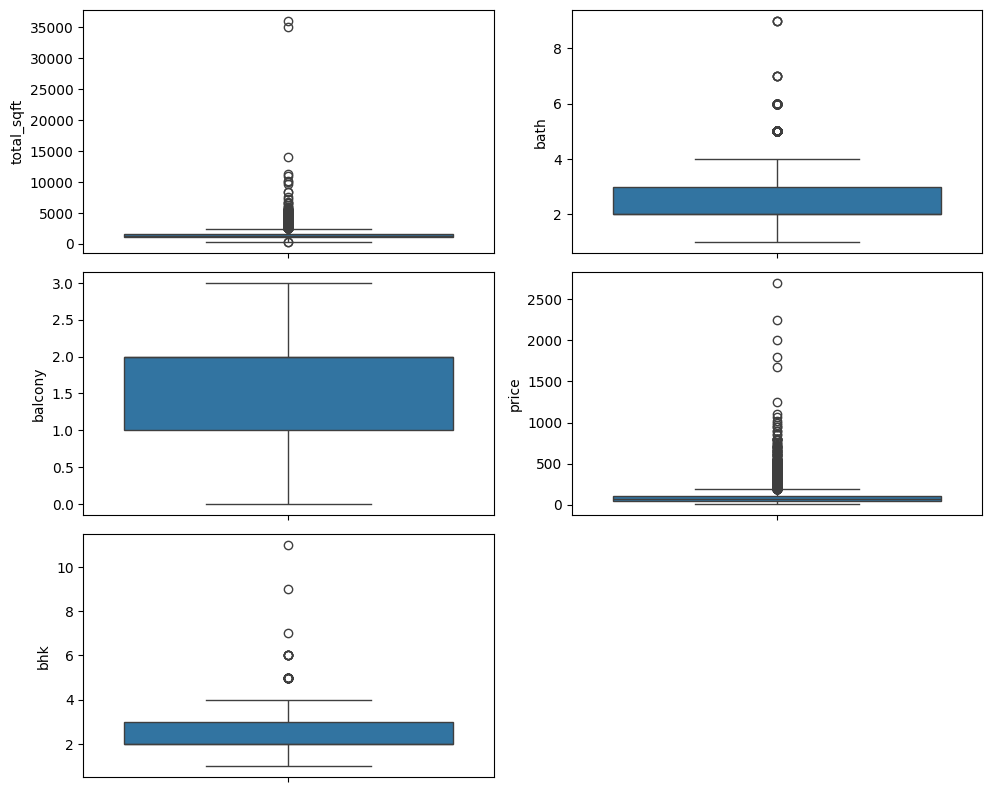

In [85]:
fig = plt.figure(figsize = (10,8))
for index,col in enumerate(cont_):
    plt.subplot(3,2,index+1)
    sns.boxplot(y = cont_.loc[:,col])
fig.tight_layout(pad = 1.0)

In [86]:
home = home.drop(home[home['bath']>6].index)
home = home.drop(home[home['bhk']>7.0].index)

In [87]:
home['price_per_sqft'] = home['price']*100000/home['total_sqft']
home.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6245.890861
3,Super built-up Area,Ready To Move,Whitefield,2 BHK,1170.0,2.0,1.0,38.00,2,3247.863248
4,Plot Area,Ready To Move,Whitefield,4 Bedroom,2785.0,5.0,3.0,295.00,4,10592.459605


In [88]:
home['price_per_sqft'].describe()

count     7471.000000
mean      5853.051952
std       2720.468727
min        371.428571
25%       4277.681409
50%       5315.315315
75%       6693.387739
max      76530.612245
Name: price_per_sqft, dtype: float64

<h3 style="background-color: #e9ecef; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #495057; 
           border: 2px solid #adb5bd; 
           border-radius: 8px">
Taking Values Within 1st Standard Deviation <br> <small style="color: #6c757d;">As per Normal Distribution, 95% of our data lies within 1st Standard Deviation</small>
</h3>

In [89]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
home = remove_pps_outliers(home)
home.shape

(5389, 10)

<h3 style="background-color: #f8f9fa; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #343a40; 
           border: 2px solid #6c757d; 
           border-radius: 8px">
Finding Correlation Values <br> <small style="color: #6c757d;">Removing features highly correlated with each other as they do not provide additional significance to the model</small>
</h3>

In [51]:
# import plotly.graph_objects as go

# corr = home.corr(numeric_only=True)

# # Masking correlations less than 0.8
# mask = corr < 0.8
# corr_masked = corr.copy()
# corr_masked[mask] = np.nan

# fig = go.Figure(data=go.Heatmap(
#     z=corr_masked.values,
#     x=corr_masked.columns,
#     y=corr_masked.columns,
#     colorscale='Blues',
#     zmin=-1, zmax=1,
#     colorbar=dict(title='Correlation'),
#     showscale=True
# ))

# fig.update_layout(
#     title='Correlation Heatmap',
#     xaxis_title='Features',
#     yaxis_title='Features',
#     xaxis=dict(tickvals=list(corr_masked.columns), ticktext=list(corr_masked.columns)),
#     yaxis=dict(tickvals=list(corr_masked.columns), ticktext=list(corr_masked.columns)),
#     height=800,  # Adjust height for better fit
#     width=800,   # Adjust width for better fit
#     margin=dict(l=50, r=50, t=50, b=50)
# )

# fig.show()

In [90]:
home.drop(columns=['availability','size','area_type'],inplace = True)

<h3 style="background-color: #f1f3f5; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #212529; 
           border: 2px solid #ced4da; 
           border-radius: 8px">
Checking Dataset with Highest Location Data <br> <small style="color: #6c757d;">Because having values for a location less than 10 won't provide significant information for the dataset</small>
</h3>


In [91]:
home.location = home.location.str.strip()
location_stats = home['location'].value_counts(ascending=False)
location_stats

location
Whitefield            357
Sarjapur  Road        240
Electronic City       225
Kanakpura Road        157
Yelahanka             141
                     ... 
Vadarpalya              1
Veer Sandra             1
Varsova Layout          1
2nd Phase JP Nagar      1
Veersandra              1
Name: count, Length: 430, dtype: int64

<h3 style="background-color: #e9ecef; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #495057; 
           border: 2px solid #adb5bd; 
           border-radius: 8px">
Creating a Series of Locations with Fewer Than 10 Entries <br> <small style="color: #6c757d;">Identifying locations with less than 10 entries to assess their impact on the dataset</small>
</h3>

In [92]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
5th Phase JP Nagar    10
Gubbalala             10
Munnekollal           10
Neeladri Nagar        10
Kannamangala          10
                      ..
Vadarpalya             1
Veer Sandra            1
Varsova Layout         1
2nd Phase JP Nagar     1
Veersandra             1
Name: count, Length: 319, dtype: int64

In [93]:
home.location = home.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

home = home[home.location != 'other']

<h3 style="background-color: #f8f9fa; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #343a40; 
           border: 2px solid #6c757d; 
           border-radius: 8px">
Ensuring Bathroom Count ≤ BHK + 2 <br> <small style="color: #6c757d;">Example: For a 3 BHK, the number of bathrooms shouldn't exceed 5</small>
</h3>

In [94]:
home = home[home.bath<home.bhk+2]

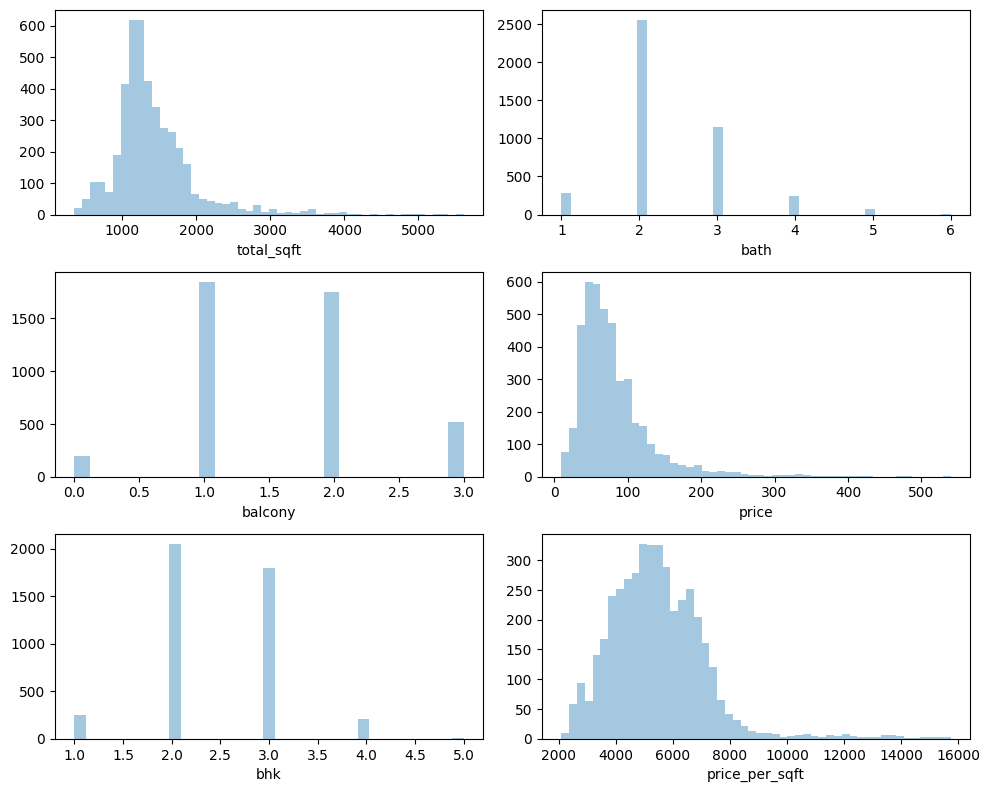

In [95]:
num_ = home.select_dtypes(exclude = 'object')
fig = plt.figure(figsize =(10,8))
for index, col in enumerate(num_):
    plt.subplot(3,2,index+1)
    sns.distplot(num_.loc[:,col],kde = False)
fig.tight_layout(pad = 1.0)  

<h3 style="background-color: #f1f3f5; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #212529; 
           border: 2px solid #ced4da; 
           border-radius: 8px">
Performing One-Hot Encoding on Categorical Values <br> <small style="color: #6c757d;">1st Step: Create Dummies</small>
</h3>

In [107]:
dummies = pd.get_dummies(home.location)


7th Phase JP Nagar  8th Phase JP Nagar  9th Phase JP Nagar  Abbigere  Akshaya Nagar  Ambalipura  Ambedkar Nagar  Ardendale  Attibele  BTM 2nd Stage  Balagere  Banashankari  Bannerghatta Road  Begur  Begur Road  Bellandur  Bhoganhalli  Binny Pete  Bisuvanahalli  Bommasandra  Brookefield  Budigere  CV Raman Nagar  Chandapura  Channasandra  Choodasandra  Devanahalli  Doddathoguru  EPIP Zone  Electronic City  Electronic City Phase II  Electronics City Phase 1  Frazer Town  Gottigere  Green Glen Layout  Gunjur  HSR Layout  Haralur Road  Harlur  Hebbal  Hebbal Kempapura  Hegde Nagar  Hennur  Hennur Road  Hoodi  Horamavu Agara  Hormavu  Hosa Road  Hosakerehalli  Hoskote  Hosur Road  Hulimavu  Iblur Village  Indira Nagar  JP Nagar  Jakkur  Jalahalli  Jigani  KR Puram  Kadugodi  Kaggadasapura  Kaggalipura  Kalena Agrahara  Kambipura  Kammasandra  Kanakapura  Kanakpura Road  Kasavanhalli  Kengeri  Kengeri Satellite Town  Kereguddadahalli  Kodichikkanahalli  Koramangala  Kothanur  Kudlu  Kudlu Ga

In [97]:

home = pd.concat([home,dummies],axis='columns')

home1 = home.drop('location',axis = 1)

home1 = home1.drop(columns=['balcony','price_per_sqft'])

In [102]:
home1.reset_index(drop = True)

,total_sqft,bath,price,bhk,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Abbigere,Akshaya Nagar,Ambalipura,...,Thubarahalli,Tumkur Road,Uttarahalli,Varthur,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,550.0,1.0,27.00,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,440.0,1.0,28.00,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,510.0,1.0,25.25,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,510.0,1.0,25.25,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1080.0,2.0,72.00,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4298,1169.0,2.0,64.08,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4299,2500.0,3.0,138.00,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4300,1160.0,2.0,64.08,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4301,2503.0,3.0,138.00,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [103]:
home1.to_csv('data/unique_locations_new.csv', index=False)

In [99]:

X = home1.drop('price',axis = 1).values 
y = home1.price.values 

In [100]:
y = y[:,np.newaxis]

#  Preprocessing Data Values with StandardScaler 📏

<h3 style="background-color: #e9ecef; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #495057; 
           border: 2px solid #adb5bd; 
           border-radius: 8px;
           margin: 0;">
 Preprocessing Data Values with StandardScaler
</h3>

In [101]:
sc = preprocessing.StandardScaler()
X1 = sc.fit_transform(X)


In [64]:
Std_x1 = preprocessing.scale(X)

# ⚙️ Model Building 🔧


<h3 style="background-color: #f8f9fa; 
           padding: 15px; 
           font: bold 22px Arial; 
           color: #343a40; 
           border: 2px solid #6c757d; 
           border-radius: 8px">
Regression Model Building
</h3>

In [65]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from sklearn.model_selection import cross_validate as CV

In [66]:
cross1 = cross_val_score(lr,Std_x1,y,cv=5,scoring='neg_mean_squared_error')
print(cross1.mean())

-2.734581717374955e+30


In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size=0.3,random_state=10)

In [68]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [69]:
models = [
    LinearRegression(),
    Ridge(),
    Lasso(alpha=1.0),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
]

In [70]:
model_names = []
mae_Accuracy=[]
mse_Accuracy=[]
r2_Accuracy=[]

for algo in models:
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test, y_pred)
    model_names.append(algo.__class__.__name__)
    mae_Accuracy.append(mae)
    mse_Accuracy.append(mse)
    r2_Accuracy.append(r2)

In [71]:
model_df = pd.DataFrame({
    'Model': model_names,
    'mae_Accuracy': mae_Accuracy,
    'mse_Accuracy': mse_Accuracy,
    'r2_Accuracy': r2_Accuracy,
        })

In [72]:
model_df.sort_values(by='r2_Accuracy',ascending=False)

,Model,mae_Accuracy,mse_Accuracy,r2_Accuracy
5,RandomForestRegressor,9.153982,222.793576,0.904354
1,Ridge,10.355644,235.393186,0.898945
0,LinearRegression,10.353748,235.443096,0.898923
6,GradientBoostingRegressor,11.759088,263.885183,0.886713
2,Lasso,12.546938,288.335751,0.876216
4,DecisionTreeRegressor,10.120806,331.161370,0.857831
3,ElasticNet,13.668323,382.488912,0.835796
